In [67]:
########### kamień milowy drugi - inżynieria cech + wstępne modelowanie

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn 
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [92]:
df = pd.read_csv(".\\dane\\training_sample_team4.csv")

### dane testowe czy tam walidacyjne 
test = pd.read_csv(".\\dane\\validation_sample_team4.csv")

In [69]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237651e+18,147.392648,0.145509,23.62785,21.78850,21.73961,21.88235,21.43752,1239,301,4,181,4.308885e+18,QSO,2.333820,3827,55565,240
1,1.237665e+18,157.156740,35.327317,18.60880,17.52187,17.12905,16.95103,16.89711,4518,301,6,192,2.204664e+18,GALAXY,0.043298,1958,53385,553
2,1.237667e+18,94.688025,63.535297,18.16716,16.51485,15.75641,15.35805,15.23041,5060,301,1,100,2.588464e+18,STAR,-0.000342,2299,53711,74
3,1.237655e+18,214.420238,-1.506597,19.83027,18.47293,17.82672,17.48600,17.26200,2334,301,5,124,1.032563e+18,GALAXY,0.081886,917,52400,411
4,1.237668e+18,204.749167,17.703206,19.33024,18.16558,17.74244,17.48129,17.32534,5314,301,1,181,2.935343e+18,GALAXY,0.061780,2607,54184,443


In [70]:
### 1. usunięcie tego co było w pierszym notatniku:
## Usuwanie kolumn o współczynniku korelacji 1 (run_ID, spec_obj_ID) oraz kolumny rerun_ID, która dla każdego rekorku 
## przyjmowała tą samą wartość
df = df.loc[:, df.columns != 'rerun_ID']
df = df.loc[:, df.columns != 'run_ID']
df = df.loc[:, df.columns != 'spec_obj_ID']

## Usuwanie błędnego wiersza
df = df[df['u'] > 0]
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,cam_col,field_ID,class,redshift,plate,MJD,fiber_ID
0,1.237651e+18,147.392648,0.145509,23.62785,21.78850,21.73961,21.88235,21.43752,4,181,QSO,2.333820,3827,55565,240
1,1.237665e+18,157.156740,35.327317,18.60880,17.52187,17.12905,16.95103,16.89711,6,192,GALAXY,0.043298,1958,53385,553
2,1.237667e+18,94.688025,63.535297,18.16716,16.51485,15.75641,15.35805,15.23041,1,100,STAR,-0.000342,2299,53711,74
3,1.237655e+18,214.420238,-1.506597,19.83027,18.47293,17.82672,17.48600,17.26200,5,124,GALAXY,0.081886,917,52400,411
4,1.237668e+18,204.749167,17.703206,19.33024,18.16558,17.74244,17.48129,17.32534,1,181,GALAXY,0.061780,2607,54184,443


In [71]:
### 2. usunięcie silnie skorelowanych kolumn
rem = ['i', 'g', 'z', 'MJD']
df = df.drop(rem, axis = 1)
df.head()

,obj_ID,alpha,delta,u,r,cam_col,field_ID,class,redshift,plate,fiber_ID
0,1.237651e+18,147.392648,0.145509,23.62785,21.73961,4,181,QSO,2.333820,3827,240
1,1.237665e+18,157.156740,35.327317,18.60880,17.12905,6,192,GALAXY,0.043298,1958,553
2,1.237667e+18,94.688025,63.535297,18.16716,15.75641,1,100,STAR,-0.000342,2299,74
3,1.237655e+18,214.420238,-1.506597,19.83027,17.82672,5,124,GALAXY,0.081886,917,411
4,1.237668e+18,204.749167,17.703206,19.33024,17.74244,1,181,GALAXY,0.061780,2607,443


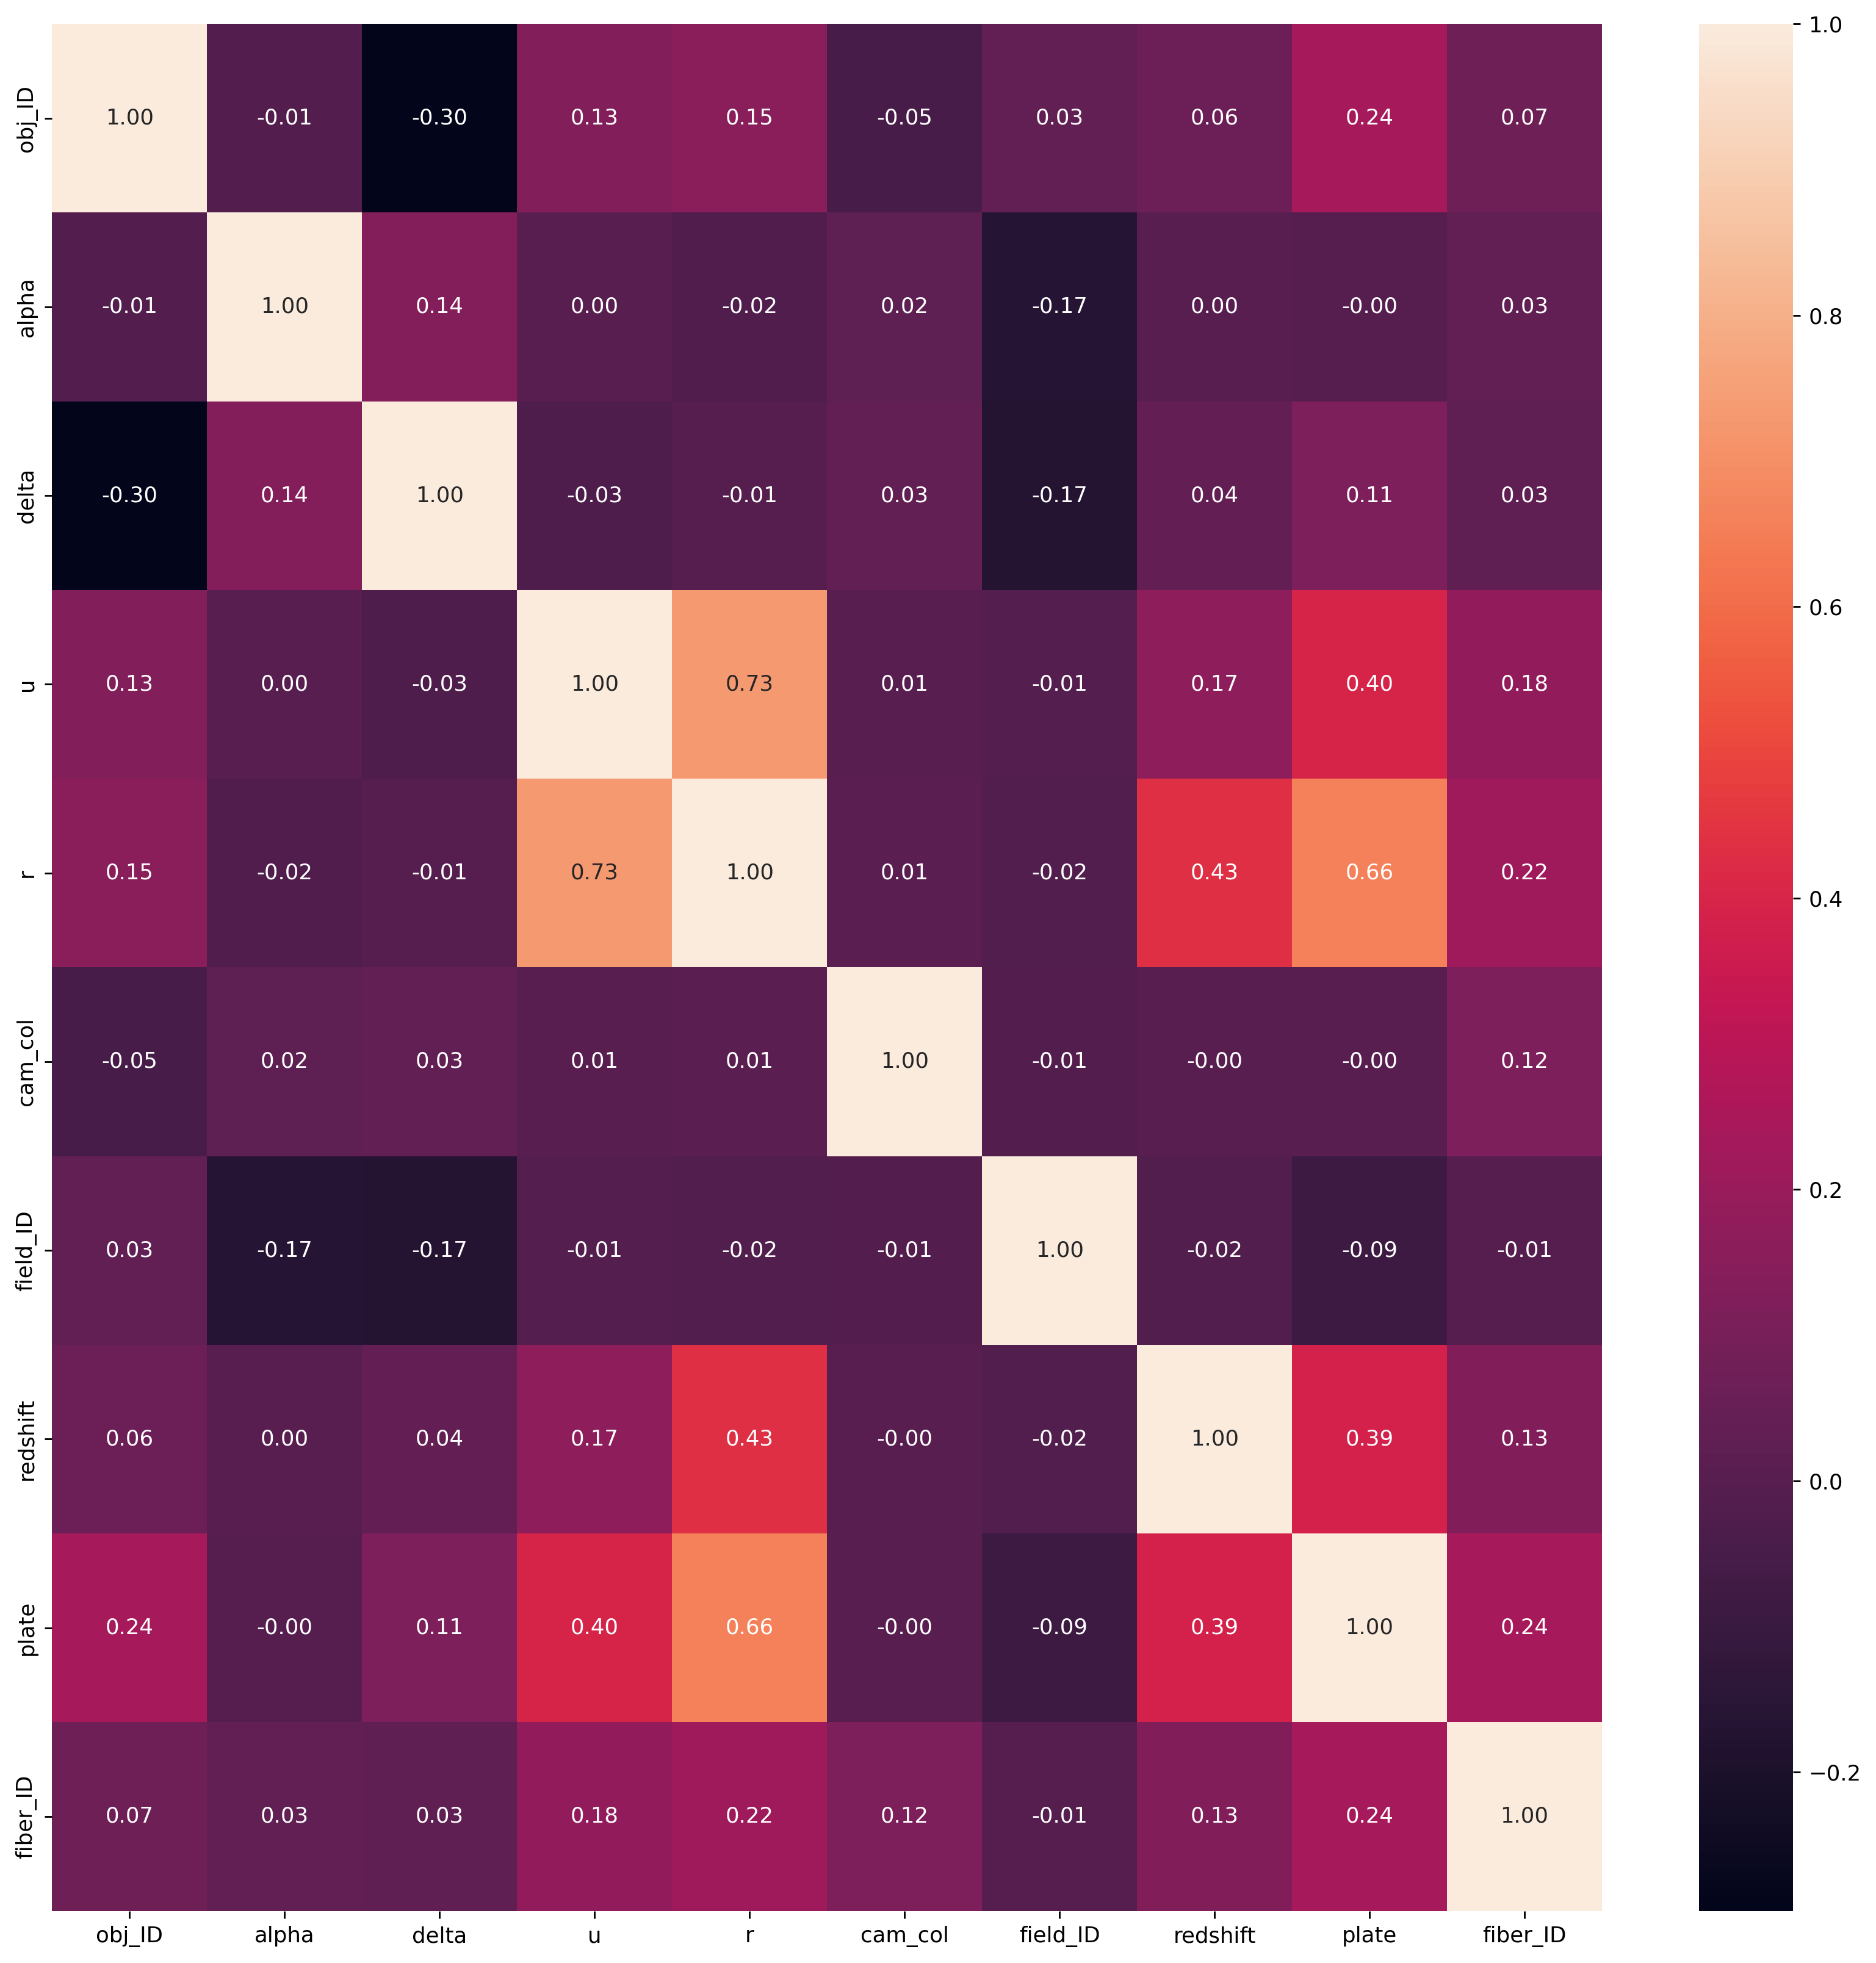

In [72]:
## jeszcze raz macierz korelacji -> widzimy, że usunęliśmy najbardziej skorelowane kolumny
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(16,16), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.2f')
plt.show()

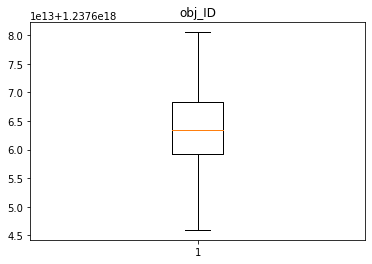

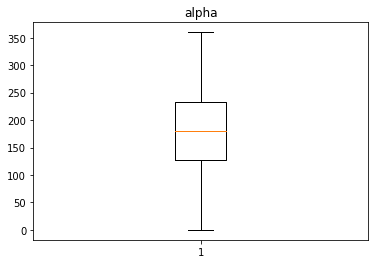

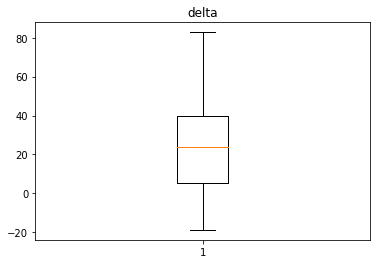

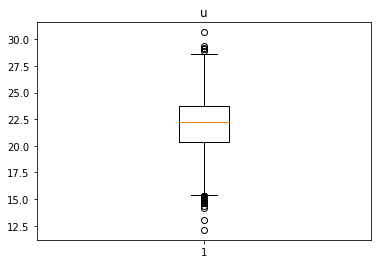

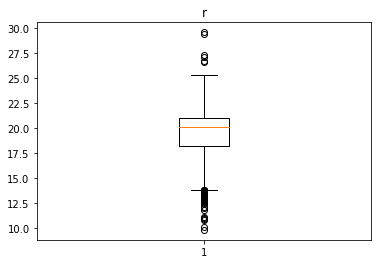

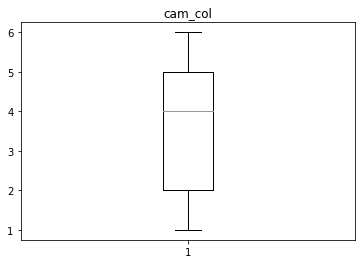

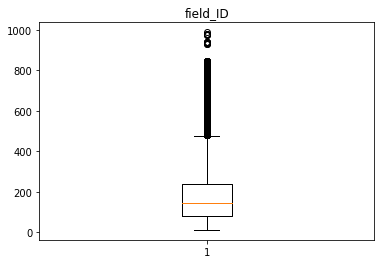

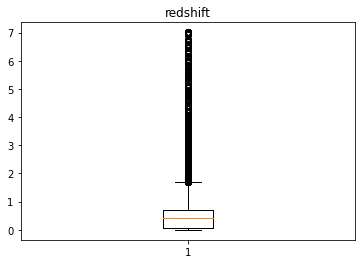

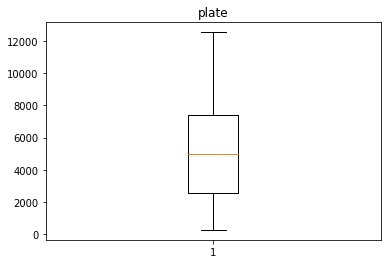

In [73]:
## 3. usuwanie OUTLIERS: zobaczmy, dla których zmiennych wystąpują wartości odstające
for i in range(10):
    if i != 7:
        plt.boxplot(df.iloc[:, i])
        plt.title(df.columns[i])
        plt.show()


In [74]:
### przyjrzyjmy się outlierom w kolumnach 'u', 'r' jeszcze raz:

In [75]:
columns_to_be_checked = ['r', 'u']

for i in range(len(columns_to_be_checked)):
    column = df[columns_to_be_checked[i]]
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)

    IQR = Q3 - Q1

    outliers = (column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR))

    outliers_count = outliers.sum()

    outliers_percentage = outliers.mean() * 100
    df = df[~outliers]
    print(outliers_count)
    print("Ilość outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_count)
    print("Procentowy udział outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_percentage)
    
    ## usuńmy outliery dla u i r: stanowią tylko 0.13% i 0.03% wszystkich wierszy

63
Ilość outlierów dla kolumny  r :  63
Procentowy udział outlierów dla kolumny  r :  0.12857142857142856
13
Ilość outlierów dla kolumny  u :  13
Procentowy udział outlierów dla kolumny  u :  0.026564766945256148


In [76]:
len(df)

48924

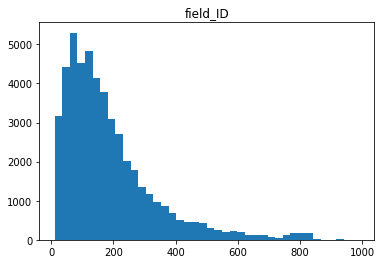

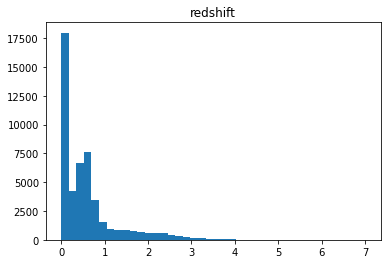

In [77]:
### spójrzmy jeszcze na dwie pozostałe kolumny z outlierami:

plt.hist(df.iloc[:, 6], bins = 40)
plt.title(df.columns[6])
plt.show()

plt.hist(df.iloc[:, 8], bins = 40)
plt.title(df.columns[8])
plt.show()

## zmienne redshift oraz filed_ID mają rozkład wykładniczy -> chyba nie usuwamy outlierów ???

In [78]:
### 4. Standaryzacja
scaler = MinMaxScaler()
columns_to_standardize = ['obj_ID', 'fiber_ID', 'alpha', 'delta', 'redshift', 'plate', 'cam_col', 'u', 'r', 'field_ID']
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [79]:
## 5. Normalizacja
scaler = StandardScaler()
columns_to_normalize = ['u'] ## -> histogram zmiennej u przypomina rozkład normalny
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [80]:
df.head()

,obj_ID,alpha,delta,u,r,cam_col,field_ID,class,redshift,plate,fiber_ID
0,0.140316,0.409416,0.186325,0.678915,0.687111,0.6,0.173824,QSO,0.333567,0.289960,0.239239
1,0.547512,0.436539,0.532598,-1.561362,0.285739,1.0,0.185072,GALAXY,0.007216,0.137774,0.552553
2,0.614736,0.263012,0.810232,-1.758490,0.166244,0.0,0.091002,STAR,0.000999,0.165540,0.073073
3,0.276301,0.595607,0.170064,-1.016153,0.346475,0.8,0.115542,GALAXY,0.012714,0.053009,0.410410
4,0.646276,0.568743,0.359134,-1.239344,0.339138,0.0,0.173824,GALAXY,0.009850,0.190620,0.442442


In [81]:
### 6. Zrównoważenie liczby kategorii algorytmem SMOTE
from imblearn.over_sampling import SMOTE
y = df['class']
df = df.drop('class', axis=1)
smote = SMOTE()
df, y_resampled = smote.fit_resample(df, y)
df['class'] = pd.DataFrame(y_resampled)


In [82]:
### Zmiana zmiennej 'class' metodą one-hot
#df['is'] = df['class']
#df = pd.get_dummies(df, columns = ['is'], dtype=float)
#df.head()
#df.drop('class', axis = 1)

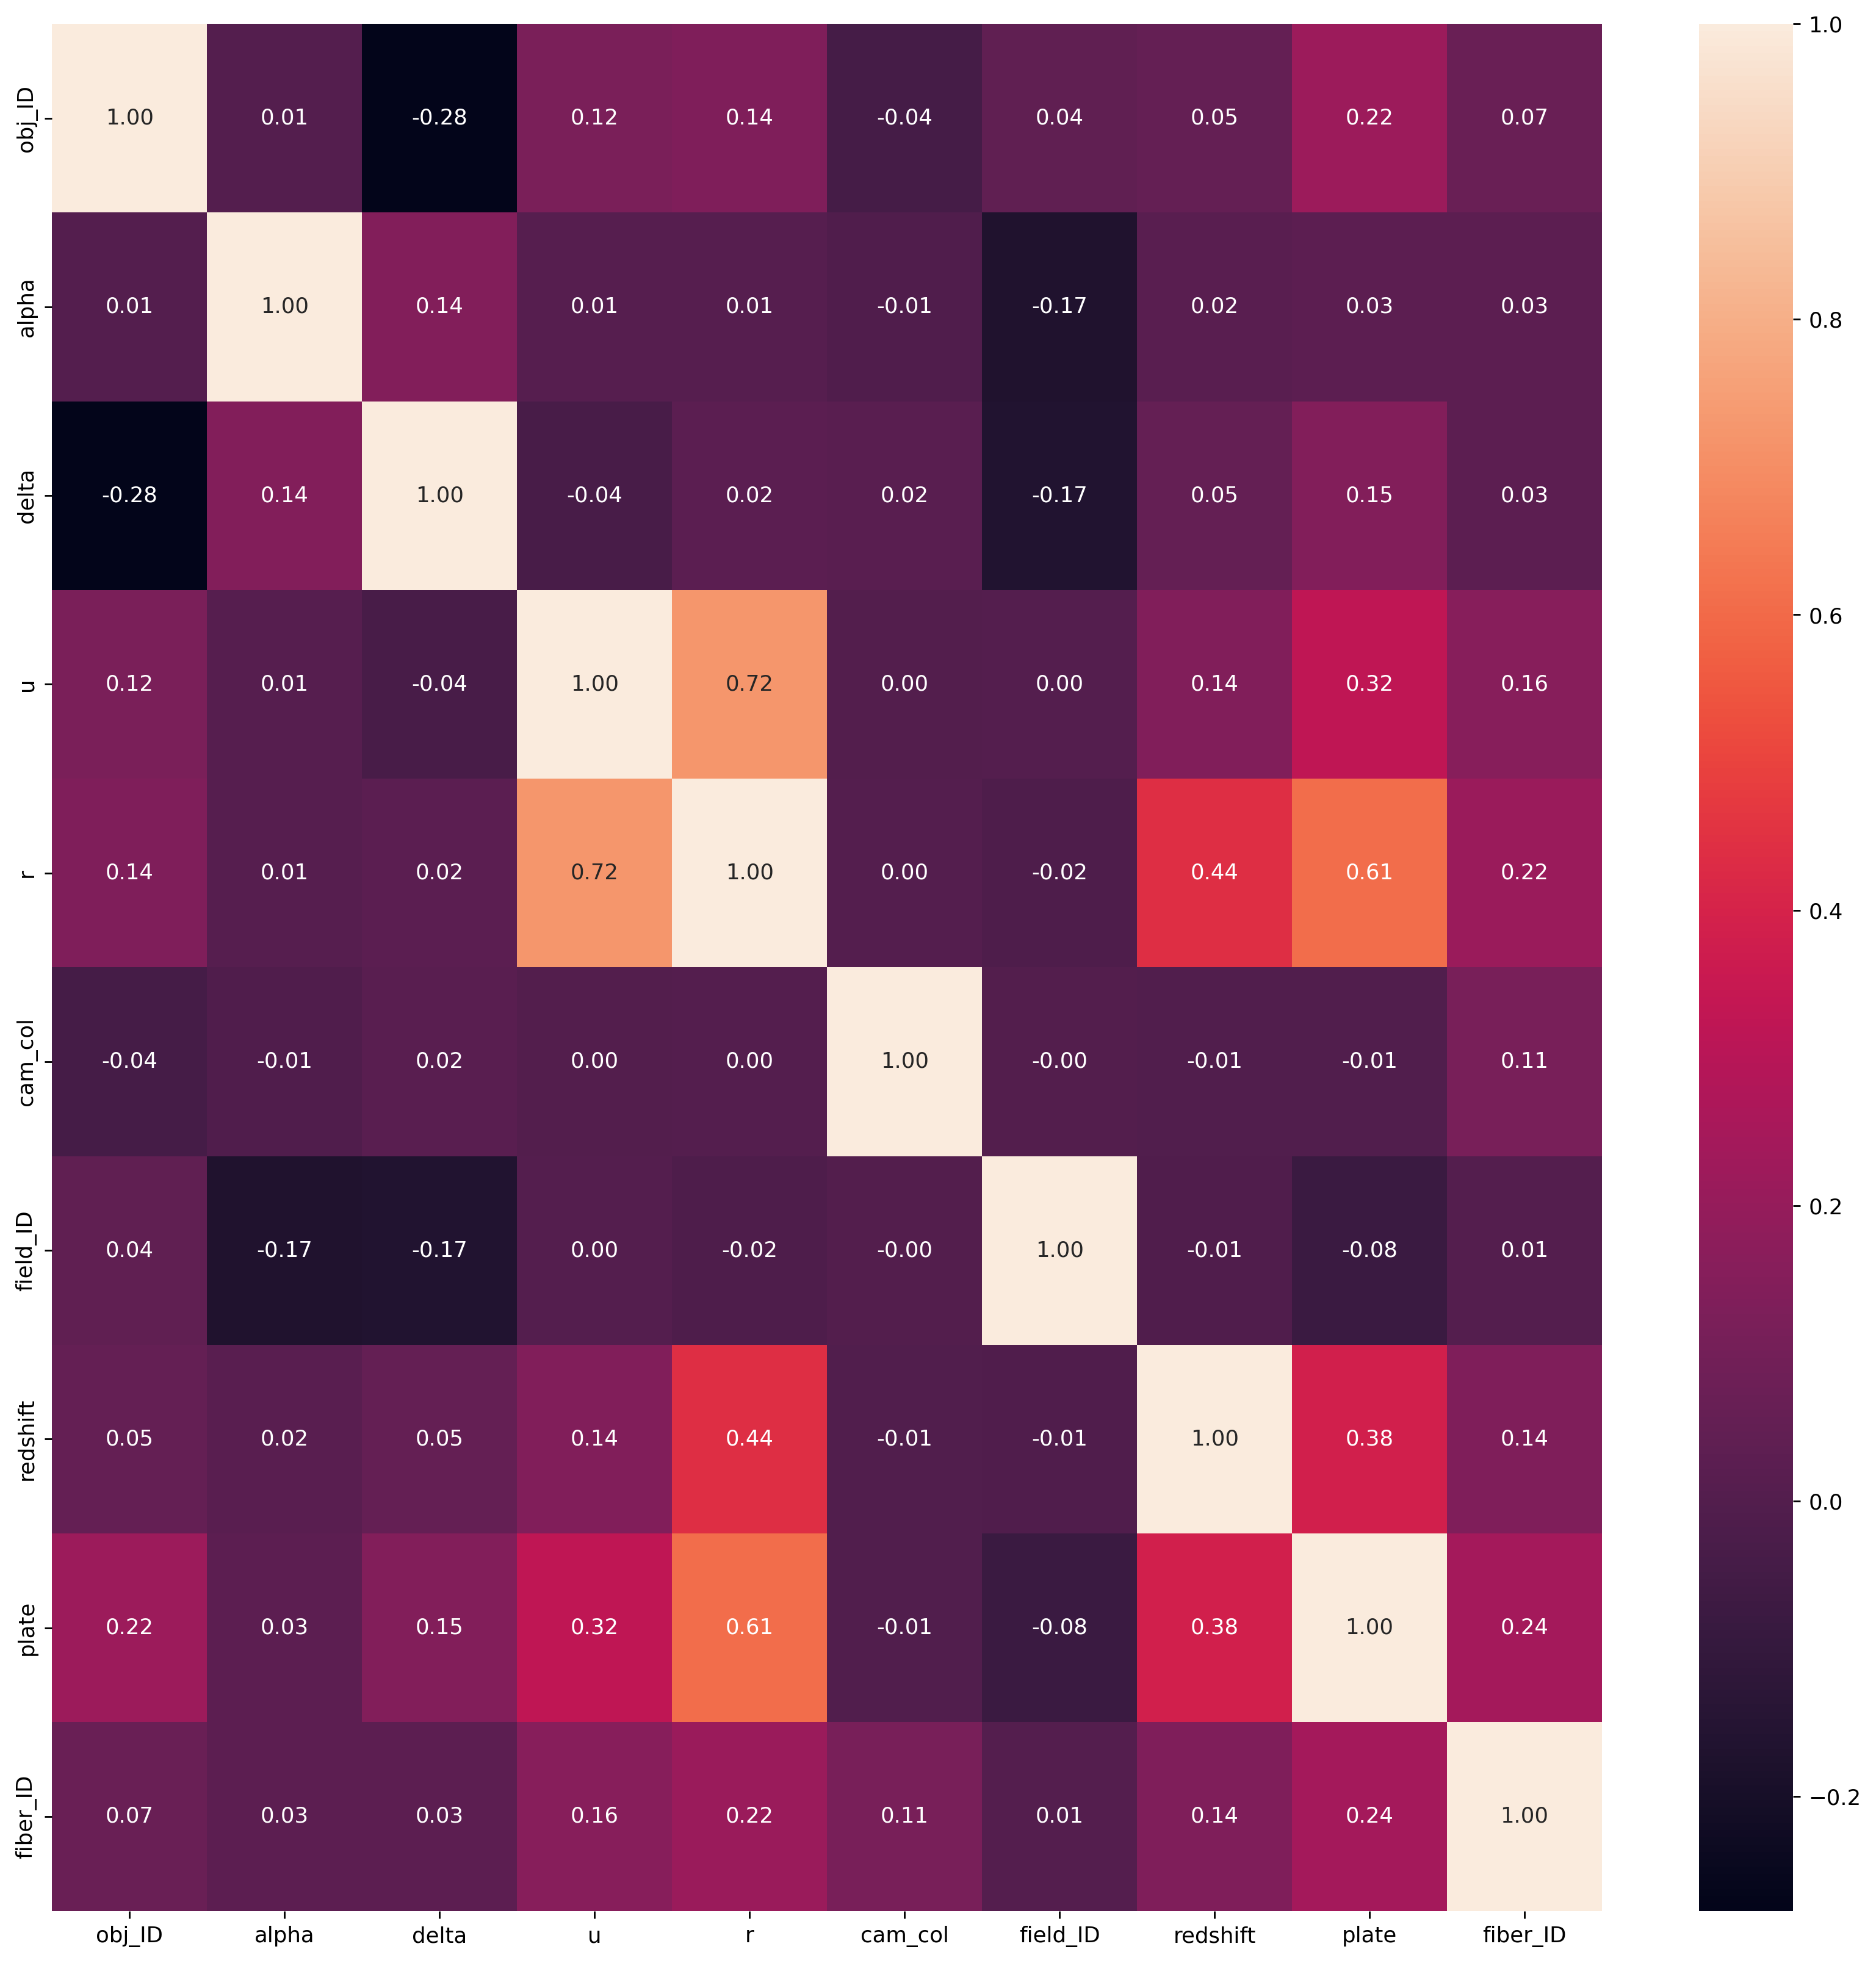

In [83]:
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(16,16), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.2f')
plt.show()

In [84]:
### przerobienie dla testowego zbioru
test = test.loc[:, test.columns != 'rerun_ID']
test = test.loc[:, test.columns != 'run_ID']
test = test.loc[:, test.columns != 'spec_obj_ID']

#### ten sam kod, teraz dla danych walidacyjnych

### 2. usunięcie silnie skorelowanych kolumn
rem = ['i', 'g', 'z', 'MJD']
test = test.drop(rem, axis = 1)

### 4. Standaryzacja
scaler = MinMaxScaler()
columns_to_standardize = ['obj_ID', 'fiber_ID', 'alpha', 'delta', 'redshift', 'plate', 'cam_col', 'u', 'r', 'field_ID']

test[columns_to_standardize] = scaler.fit_transform(test[columns_to_standardize])

## 5. Normalizacja
scaler = StandardScaler()
columns_to_normalize = ['u'] ## -> histogram zmiennej u przypomina rozkład normalny
test[columns_to_normalize] = scaler.fit_transform(test[columns_to_normalize])



In [85]:
########## jakieś wstępne, przykładowe modele (jeszcze nie kodowałam zmiennej class)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train = df.drop('class', axis=1)
y_train = df['class']

X_test = test.drop('class', axis=1)
y_test = test['class']

In [86]:
#X = df.drop('class', axis=1)
#y = df['class']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu:", accuracy)

Dokładność modelu: 0.8504285714285714


In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu:", accuracy)

Dokładność modelu: 0.7572857142857143


In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(random_state=42)  # Ustawiamy random_state dla powtarzalności wyników
model.fit(X_train, y_train)

# Przewiduj dla danych testowych
y_pred = model.predict(X_test)

# Oceń dokładność modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu:", accuracy)

Dokładność modelu: 0.8754285714285714


In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu:", accuracy)

Dokładność modelu: 0.9655238095238096


In [90]:
### uwagi, ciekawostki, spostrzeżenia:
# 1. przy zamianie outlierow z kolumn field_ID, redshift lub ich usunięciu, dokładności przykładowych 
# modeli spadają do około 40 - 50 %
# 2. normalizacja przed standaryzacją daje gorsze wyniki, bez standaryzacji zmiennej u też są gorsze wyniki
# 3. można się jeszcze zastanowić nad usunięciem zmiennej 'r' ponieważ ma ona korelację z zmienną 'u' równą 0.73 
# (co jest dosyć sporo) + bez tej zmiennej model ma porównywalną precyzyjność